# Modellbildung

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, Image, Markdown
from scipy.optimize import leastsq
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

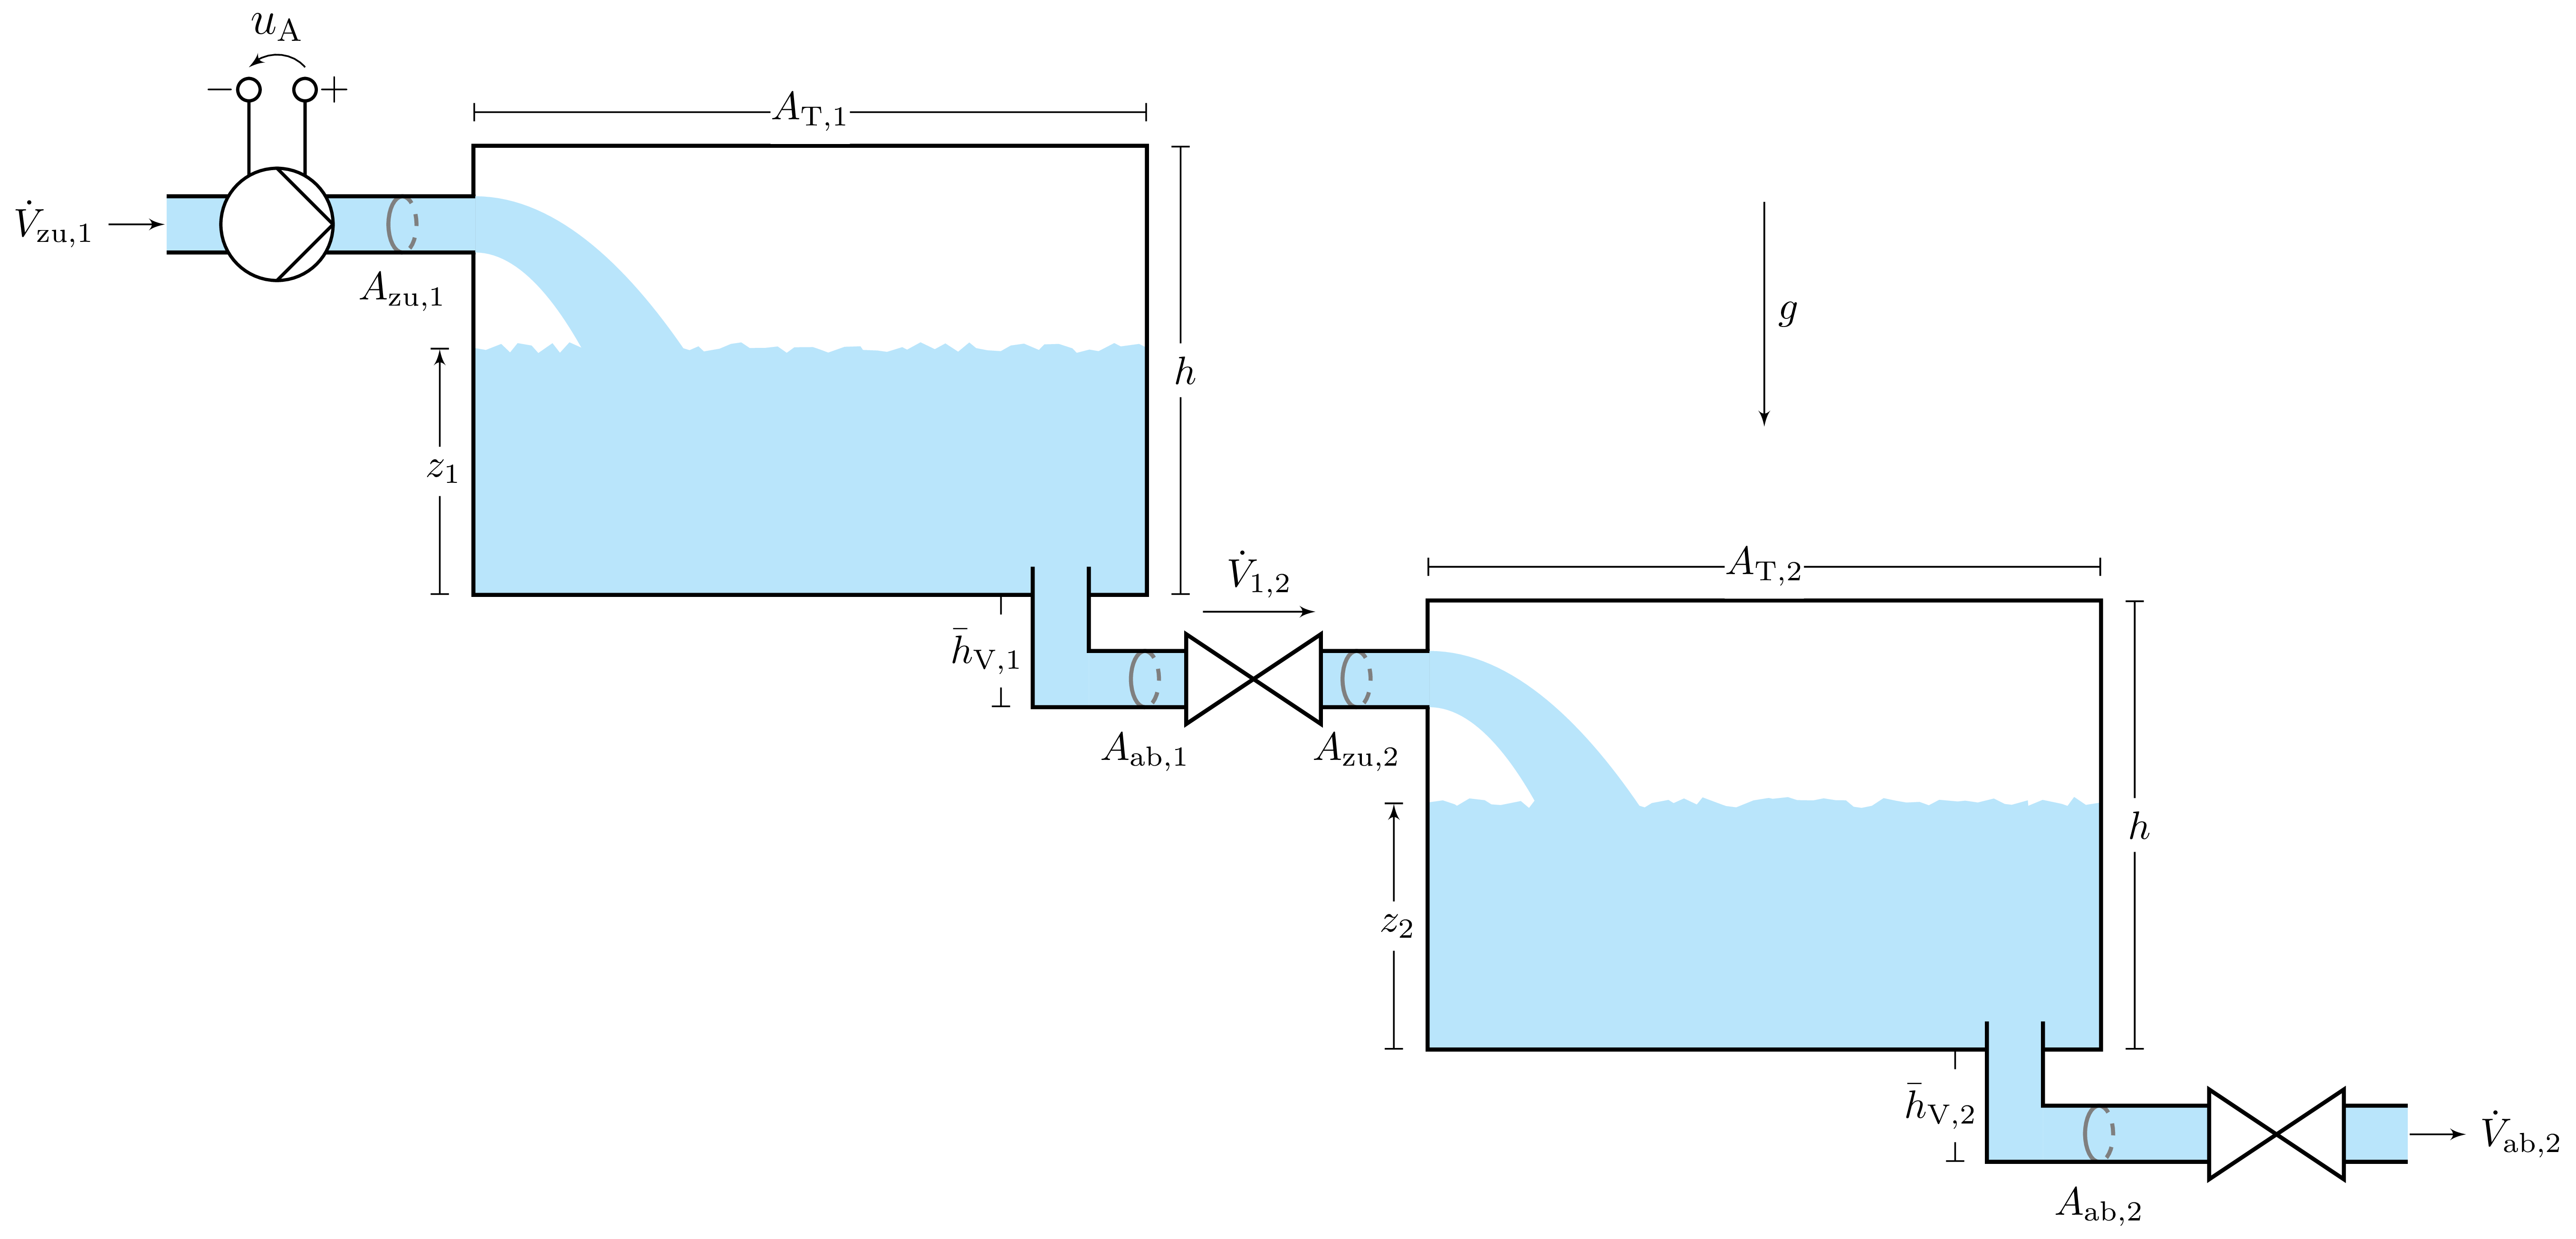

In [2]:
imag = Image("../images/twoTank.png", width=600)
display(imag)

Ziel ist die Erarbeitung eines linearen Modells, welches das Eingangs-Ausgangsverhaltens für den verwendeten Prüfstand abbildet um dann für den Steuerungs- und Reglerentwurf als Basis zu dienen.
Aus der Übung ist das Systemverhalten für den nichtlinearen Tanksystem bekannt.
Ebenso wurde das linearisierte Modell des Tanksystems als System zweiter Ordnung der Form
\begin{align*}
    T_1T_2\ddot{\tilde{z}}_2(t) + (T_1 + T_2)\dot{\tilde{z}}_2(t) + \tilde{z}_2(t) & = K \tilde{u}_{\text{A}}(t)
\end{align*}
identifiziert.

Nachfolgend sollen nun die Zeitkonstanten $T_1$, $T_2$, die Verstärkung $K$ und die Ruhelagenhöhe $\bar{z}_2$ für die Ruhelagenspannung $\bar{u}_{\text{A}} = 9\, \text{V}$ aus einer Messung ermittelt werden.

### Messdaten einlesen

In [3]:
messung = pd.read_csv('../../python/data/aufbau1_tank1tank2.csv')
messung.bfill(inplace=True)

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not

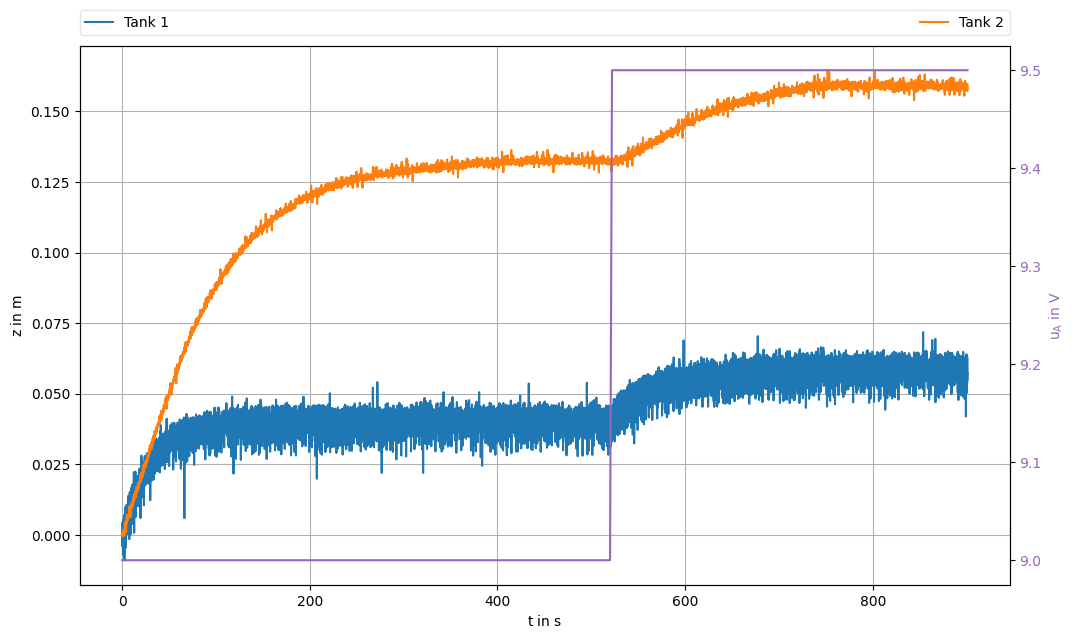

In [4]:
plt.close()

fig1, axes10 = plt.subplots(1, 1, figsize=(12,7))

axes10.plot(messung['time'], messung['HeightT1'], label=r'Tank 1')
axes10.plot(messung['time'], messung['HeightT2'], label=r'Tank 2')

axes11 = axes10.twinx() 

axes11.plot(messung['time'], messung['Traj y'], color='C4')
axes11.tick_params(axis='y', labelcolor='C4')

axes10.set_ylabel(r'$z$ in m')
axes11.set_ylabel(r'$u_{\mathrm{A}}$ in V', color='C4')
axes10.set_xlabel(r'$t$ in s')

handlesAx1, labelsAx1 = axes10.get_legend_handles_labels()
axes10.legend([handle for i, handle in enumerate(handlesAx1)],
              [label for i, label in enumerate(labelsAx1)],
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=9, mode="expand", borderaxespad=0., framealpha=0.5)

axes10.grid()
plt.show()

### 1. Bestimmung Ruhelagenhöhe für Tank 1 und Tank 2

* Auswahl des Zeitfensters in Zehntelsekunden

In [5]:
dt = messung['time'][2] - messung['time'][1]

In [6]:
startZeit = 400
endZeit = 475
startIdx = int(startZeit / dt)
endIdx = int(endZeit / dt)
rlZeit = messung['time'][startIdx:endIdx]
rlHoeheT1 = messung['HeightT1'][startIdx:endIdx]
rlHoeheT2 = messung['HeightT2'][startIdx:endIdx]
rlUa = messung['Traj y'][startIdx:endIdx]

In [7]:
buAMessung = np.mean(rlUa)
bz1Messung = np.mean(rlHoeheT1)
bz2Messung = np.mean(rlHoeheT2)

display(Markdown(rf"""
$\bar{{u}}_\text{{A}} = {buAMessung}$, &nbsp; $\bar{{z}}_{{1}} = {bz1Messung}$, &nbsp; $\bar{{z}}_{{2}} = {bz2Messung}$
"""))


$\bar{u}_\text{A} = 9.0$, &nbsp; $\bar{z}_{1} = 0.04057759540229883$, &nbsp; $\bar{z}_{2} = 0.13238994944989588$


### 2. Bestimmung der Zeitkonstanten $T_1$ und $T_2$

* Auswahl des Zeitfensters in Zehntelsekunden
* Bestimmung der Zeitkonstanten aus Übergang $z_2=0\, \text{m}$ auf $z_2 = \bar{z}_2$ als Anfangswertüberführung:
  \begin{align*}
      z_2(t) & = \left(\frac{T_1}{T_1 - T_2} e^{-\frac{t}{T_1}} - \frac{T_2}{T_1 - T_2} e^{-\frac{t}{T_2}}\right) z_{2,0} + \frac{T_1 T_2}{T_1 - T_2} \left(e^{-\frac{t}{T_1}} - e^{-\frac{t}{T_2}} \right) \dot{z}_{2,0}
  \end{align*}

In [8]:
def pt2Analytisch(T1, T2, time, zS, dzS):
    height = np.zeros(len(time))
    for idx, t in enumerate(time):
        height[idx] = (T1 / (T1 - T2) * np.exp(-t / T1) - T2 / (T1 - T2) * np.exp(-t / T2)) * zS + \
                       T1 * T2 / (T1 - T2) * (np.exp(-t / T1) - np.exp(-t / T2)) * dzS
    return height

* Verwendung der Methode der kleinsten Quadrate (Least Squares) als Optimierungsmethode

In [9]:
def pt2Residual(params, time, measHeight, zS, dzS, z0):
    T1, T2 = params[0], params[1]
    height = pt2Analytisch(T1, T2, time, zS, dzS)
    return height + z0 - measHeight

In [10]:
startZeit = 0
endZeit = 400
startIdx = int(startZeit / dt)
endIdx = int(endZeit / dt)
TZeit = messung['time'][startIdx:endIdx]
THoeheT2 = messung['HeightT2'][startIdx:endIdx]

pOpt = leastsq(pt2Residual, 
               x0=[1, 10], 
               args=(TZeit, 
                     THoeheT2, 
                     THoeheT2[0] - bz2Messung, 
                     THoeheT2[10] - THoeheT2[0], 
                     bz2Messung))
T1Messung = pOpt[0][0]
T2Messung = pOpt[0][1]

display(Markdown(rf"""
$T_1 = {T1Messung}$, &nbsp; $T_2 = {T2Messung}$
""")) 


$T_1 = 11.796537792186554$, &nbsp; $T_2 = 80.74097995885646$


### 3. Bestimmung der Verstärkung $K$

* Auswahl des Zeitfensters in Zehntelsekunden
* Berechnung der Verstärkung $K$ aus stationären Verhalten $\ddot{\tilde{z}}_2 = \dot{\tilde{z}}_2 = 0$:
  \begin{align*}
      K & = \frac{\tilde{z}_2}{\tilde{u}_{\text{A}}} = \frac{\tilde{z}_{2,0} - \bar{z}_2}{\tilde{u}_{\text{A},0} - \bar{u}_{\text{A}}}
  \end{align*}

In [11]:
startZeit = 800
endZeit = 875
startIdx = int(startZeit / dt)
endIdx = int(endZeit / dt)
kZeit = messung['time'][startIdx:endIdx]
kHoeheT2 = messung['HeightT2'][startIdx:endIdx]
kUa = messung['Traj y'][startIdx:endIdx]

In [12]:
KMessung = (np.mean(kHoeheT2) - bz2Messung) / (np.mean(kUa) - buAMessung)

display(Markdown(rf"""
$K = {KMessung}$
"""))


$K = 0.05335540886113588$


### 4. Vergleich identifizierte Parameter mit physikalischen Parametern

In [13]:
KPhy = 0.147763421835044
T1Phy = 34.567259359529
T2Phy = 68.2115206317666
bz1Phy = 0.0423458650804235
bz2Phy = 0.137092448385557
buAPhy = 9
    
display(Markdown(rf"""
|                     | Messung     | Physikalisch  |
| :---                |    :----:   |          ---: |
| $K$                 | {KMessung}  | {KPhy}        |
| $T_1$               | {T1Messung} | {T1Phy}       |
| $T_2$               | {T2Messung} | {T2Phy}       |
| $\bar{{z}}_{{1}}$   | {bz1Messung}| {bz1Phy}      |
| $\bar{{z}}_{{2}}$   | {bz2Messung}| {bz2Phy}      |
"""))


|                     | Messung     | Physikalisch  |
| :---                |    :----:   |          ---: |
| $K$                 | 0.05335540886113588  | 0.147763421835044        |
| $T_1$               | 11.796537792186554 | 34.567259359529       |
| $T_2$               | 80.74097995885646 | 68.2115206317666       |
| $\bar{z}_{1}$   | 0.04057759540229883| 0.0423458650804235      |
| $\bar{z}_{2}$   | 0.13238994944989588| 0.137092448385557      |


#### Simulation
Definition nichtlineares Modell

In [14]:
def nonLinSys(t, z, uA):
    z1 = z[0]
    z2 = z[1]
        
    hV1 = 0.055
    hV2 = 0.055
    
    dz = np.zeros(2)
    dz[0] = 0.00216625315586689 * (uA(t) - 6.4) - 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1)
    dz[1] = 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(hV2 + z2)

    return dz

Definition linearisiertes Modell

In [15]:
def linSys(t, x, uA, A, B, buA):
    dx = A.dot(x) + B.dot(np.array([uA(t) - buA]))
    return dx

In [16]:
APhy = np.array([[0, 1],
                 [-1 / (T1Phy * T2Phy), - (T1Phy + T2Phy) / (T1Phy * T2Phy)]])
BPhy = np.array([[0],
                 [KPhy / (T1Phy * T2Phy)]])

AMessung = np.array([[0, 1],
                     [-1 / (T1Messung * T2Messung), - (T1Messung + T2Messung) / (T1Messung * T2Messung)]])
BMessung = np.array([[0],
                     [KMessung / (T1Messung * T2Messung)]])

In [17]:
timeDom = np.linspace(0, len(messung['time']), len(messung['time'])) / 10
z0 = [0, 0]
uA = interp1d(messung['time'], messung['Traj y'], fill_value="extrapolate")

resPhyLin = solve_ivp(linSys, [timeDom[0], timeDom[-1]], z0 - np.array([bz2Phy, 0]), t_eval=timeDom, args=(uA, APhy, BPhy, buAPhy))
resPhyNichtLin = solve_ivp(nonLinSys, [timeDom[0], timeDom[-1]], z0, t_eval=timeDom, args=(uA, ))
resMessung = solve_ivp(linSys, [timeDom[0], timeDom[-1]], z0 - np.array([bz2Messung, 0]), t_eval=timeDom, args=(uA, AMessung, BMessung, buAMessung))

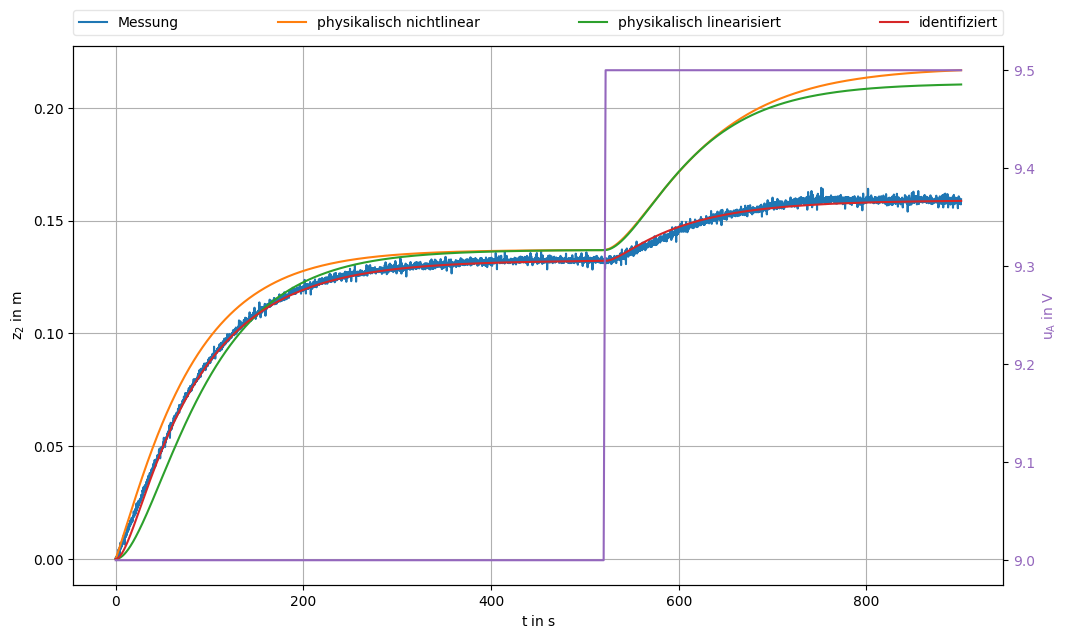

In [18]:
plt.close()

fig1, axes10 = plt.subplots(1, 1, figsize=(12,7))

axes10.plot(messung['time'], messung['HeightT2'], label=r'Messung')
axes10.plot(timeDom, resPhyNichtLin.y[1], label='physikalisch nichtlinear')
axes10.plot(timeDom, resPhyLin.y[0] + bz2Phy, label='physikalisch linearisiert')
axes10.plot(timeDom, resMessung.y[0] + bz2Messung, label=r'identifiziert')

axes11 = axes10.twinx() 

axes11.plot(messung['time'], messung['Traj y'], color='C4')
axes11.tick_params(axis='y', labelcolor='C4')

axes10.set_ylabel(r'$z_2$ in m')
axes11.set_ylabel(r'$u_{\mathrm{A}}$ in V', color='C4')
axes10.set_xlabel(r'$t$ in s')

handlesAx1, labelsAx1 = axes10.get_legend_handles_labels()
axes10.legend([handle for i, handle in enumerate(handlesAx1)],
              [label for i, label in enumerate(labelsAx1)],
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=9, mode="expand", borderaxespad=0., framealpha=0.5)

axes10.grid()
plt.show()

### 5. Bestimmung des allgemeinen Modells

Nachdem die Parameter der Differentialgleichung
\begin{align*}
    T_1T_2\ddot{\tilde{z}}_2(t) + (T_1 + T_2)\dot{\tilde{z}}_2(t) + \tilde{z}_2(t) & = K \tilde{u}_{\text{A}}(t)
\end{align*}
bestimmt worden, kann auch auf die lineare Ausgangsform
\begin{align*}
    \begin{pmatrix} \dot{\tilde{z}}_1(t) \\ \dot{\tilde{z}}_2(t)\end{pmatrix} & = \begin{pmatrix} a_{11} & 0 \\ a_{21} & a_{22} \end{pmatrix} \begin{pmatrix} \tilde{z}_1(t) \\ \tilde{z}_2(t)\end{pmatrix} + \begin{pmatrix} b_1 \\ 0\end{pmatrix} \tilde{u}_{\text{A}}(t)
\end{align*}
geschlossen werden.
Dazu sind die Parameter durch die Zusammenhänge
\begin{align*}
    a_{11} & = \frac{1}{T_1 T_2 a_{22}}, & 
    a_{22}^2 + \frac{T_1 + T_2}{T_1 T_2} a_{22} + \frac{1}{T_1 T_2} & = 0, &
\end{align*}
Zur Bestimmung von $a_{21}$ und $b_1$ wird auf stationäre Messungen zurückgegriffen:
\begin{align*}
    0 & = a_{11} \bar{z}_1 + b_1 \bar{u}_{\text{A}} & \rightarrow && b_1 & = -a_{11} \frac{\bar{z}_1}{\bar{u}_{\text{A}}} \\
    0 & = a_{21} \bar{z}_{21} + a_{22} \bar{z}_{22} & \rightarrow && a_{21} & = - a_{22} \frac{\bar{z}_2}{\bar{z}_1}
\end{align*}


In [19]:
a22Messung = - (T1Messung + T2Messung) / (2 * T1Messung * T2Messung) + np.sqrt((T1Messung + T2Messung) ** 2 / (2 * T1Messung * T2Messung) ** 2 - 1 / (T1Messung * T2Messung))
a11Messung = 1 / (T1Messung * T2Messung * a22Messung)
b1Messung = -a11Messung * bz1Messung / buAMessung
a21Messung = -a22Messung * bz2Messung / bz1Messung

a11Phy = -0.0289291085995319
a21Phy = 0.0289291085995319
a22Phy = -0.0146602801218639
b1Phy = 0.00216625315586689

In [20]:
display(Markdown(rf"""
|                     | Messung     | Physikalisch  |
| :---                |    :----:   |          ---: |
| $a_{{11}}$          | {a11Messung}       | {a11Phy} |
| $a_{{21}}$          | {a21Messung}       | {a21Phy} |
| $a_{{22}}$          | {a22Messung}       | {a22Phy} |
| $b_1$               | {b1Messung}        | {b1Phy} |
"""))


|                     | Messung     | Physikalisch  |
| :---                |    :----:   |          ---: |
| $a_{11}$          | -0.08477063504703478       | -0.0289291085995319 |
| $a_{21}$          | 0.04040868267724701       | 0.0289291085995319 |
| $a_{22}$          | -0.012385284405881311       | -0.0146602801218639 |
| $b_1$               | 0.00038219872565939        | 0.00216625315586689 |


### 6. Vergleich Eingangs-Ausgangs- und allgemeines Modell

In [21]:
AEAMessung = np.array([[0, 1],
                     [-1 / (T1Messung * T2Messung), - (T1Messung + T2Messung) / (T1Messung * T2Messung)]])
BEAMessung = np.array([[0],
                     [KMessung / (T1Messung * T2Messung)]])

AGenMessung = np.array([[a11Phy, 0],
                        [a21Phy, a22Phy]])
BGenMessung = np.array([[b1Phy],
                        [0]])

In [22]:
timeDom = np.linspace(0, len(messung['time']), len(messung['time'])) / 10
z0 = [0, 0]
uA = interp1d(messung['time'], messung['Traj y'], fill_value="extrapolate")

resEAMessung = solve_ivp(linSys, [timeDom[0], timeDom[-1]], z0 - np.array([bz2Messung, 0]), t_eval=timeDom, args=(uA, AEAMessung, BEAMessung, buAMessung))
resGenMessung = solve_ivp(linSys, [timeDom[0], timeDom[-1]], z0 - np.array([bz1Messung, bz2Messung]), t_eval=timeDom, args=(uA, AGenMessung, BGenMessung, buAMessung))

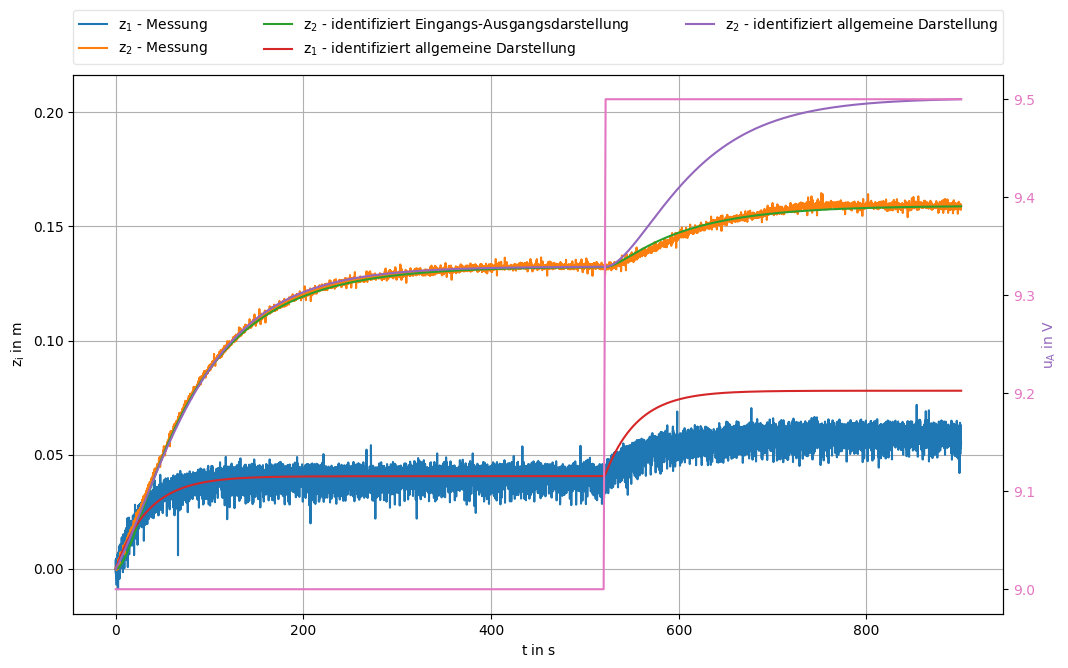

In [23]:
plt.close()

fig1, axes10 = plt.subplots(1, 1, figsize=(12,7))

axes10.plot(messung['time'], messung['HeightT1'], label=r'$z_1$ - Messung')
axes10.plot(messung['time'], messung['HeightT2'], label=r'$z_2$ - Messung')
axes10.plot(timeDom, resEAMessung.y[0] + bz2Messung, label=r'$z_2$ - identifiziert Eingangs-Ausgangsdarstellung')
axes10.plot(timeDom, resGenMessung.y[0] + bz1Messung, label=r'$z_1$ - identifiziert allgemeine Darstellung')
axes10.plot(timeDom, resGenMessung.y[1] + bz2Messung, label=r'$z_2$ - identifiziert allgemeine Darstellung')

axes11 = axes10.twinx() 

axes11.plot(messung['time'], messung['Traj y'], color='C6')
axes11.tick_params(axis='y', labelcolor='C6')

axes10.set_ylabel(r'$z_i$ in m')
axes11.set_ylabel(r'$u_{\mathrm{A}}$ in V', color='C4')
axes10.set_xlabel(r'$t$ in s')

handlesAx1, labelsAx1 = axes10.get_legend_handles_labels()
axes10.legend([handle for i, handle in enumerate(handlesAx1)],
              [label for i, label in enumerate(labelsAx1)],
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=3, mode="expand", borderaxespad=0., framealpha=0.5)

axes10.grid()
plt.show()